# **Library Imports**

In [1]:
import pandas as pd
import numpy as np
from sklearn.nn_structure_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load Dataset & Processing

In [2]:
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"Uploaded file: {file_name}")

# Load dataset
df = pd.read_csv(file_name, encoding='latin1', header=None)

df = df.iloc[:, [4, 6]]
df.columns = ['ProductTitle', 'ProductCategory']
df.dropna(inplace=True)

# Preprocessing Dataset
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['ProductTitle'])
X = tokenizer.texts_to_sequences(df['ProductTitle'])
X = pad_sequences(X)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['ProductCategory'])
num_classes = len(np.unique(y))
y = np.eye(num_classes)[y]

# Split the data
X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

Saving pricerunner_aggregate.csv to pricerunner_aggregate (8).csv
Uploaded file: pricerunner_aggregate (8).csv


# NN structure

In [3]:
class NeuralNetwork(object):

  def __init__(self):

    inputLayerNeurons = X_train.shape[1]
    hiddenLayer1Neurons = 64
    hiddenLayer2Neurons = 32
    hiddenLayer3Neurons = 16
    hiddenLayer4Neurons = 8
    outLayerNeurons = 4

    self.learning_rate = 0.0001

    self.W_H1I = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons) * np.sqrt(2.0/inputLayerNeurons)
    self.W_H2H1 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons) * np.sqrt(2.0/hiddenLayer1Neurons)
    self.W_H3H2 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons) * np.sqrt(2.0/hiddenLayer2Neurons)
    self.W_H4H3 = np.random.randn(hiddenLayer3Neurons, hiddenLayer4Neurons) * np.sqrt(2.0/hiddenLayer3Neurons)
    self.W_OH4 = np.random.randn(hiddenLayer4Neurons, outLayerNeurons) * np.sqrt(2.0/hiddenLayer4Neurons)

  def sigmoid(self, x, der=False):

    sig = 1 / (1 + np.exp(-x))
    if der:
      return sig * (1 - sig)
    return sig

  def softmax(self, x):

    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

  def feedForward(self, X):

    # Layer 1
    self.hidden1_input = np.dot(X, self.W_H1I)
    self.hidden1_output = self.sigmoid(self.hidden1_input)

    # Layer 2
    self.hidden2_input = np.dot(self.hidden1_output, self.W_H2H1)
    self.hidden2_output = self.sigmoid(self.hidden2_input)

    # Layer 3
    self.hidden3_input = np.dot(self.hidden2_output, self.W_H3H2)
    self.hidden3_output = self.sigmoid(self.hidden3_input)

    # Layer 4
    self.hidden4_input = np.dot(self.hidden3_output, self.W_H4H3)
    self.hidden4_output = self.sigmoid(self.hidden4_input)

    # Output layer
    output_input = np.dot(self.hidden4_output, self.W_OH4)
    pred = self.softmax(output_input)
    return pred

  def calculate_class_weights(self, y):
    # Calculate class weights
    class_counts = np.sum(y, axis=0)
    total_samples = np.sum(class_counts)
    class_weights = np.zeros_like(class_counts, dtype=float)
    non_zero_counts_indices = class_counts > 0
    class_weights[non_zero_counts_indices] = total_samples / (len(class_counts) * class_counts[non_zero_counts_indices])
    return class_weights

  def backPropagation(self, X, Y, pred):

    # Output layer error
    output_error = pred - Y
    delta_output = output_error

    # Layer 4
    hidden4_error = delta_output.dot(self.W_OH4.T)
    delta_hidden4 = hidden4_error * self.sigmoid(self.hidden4_output, der=True)

    # Layer 3
    hidden3_error = delta_hidden4.dot(self.W_H4H3.T)
    delta_hidden3 = hidden3_error * self.sigmoid(self.hidden3_output, der=True)

    # Layer 2
    hidden2_error = delta_hidden3.dot(self.W_H3H2.T)
    delta_hidden2 = hidden2_error * self.sigmoid(self.hidden2_output, der=True)

    # Layer 1
    hidden1_error = delta_hidden2.dot(self.W_H2H1.T)
    delta_hidden1 = hidden1_error * self.sigmoid(self.hidden1_output, der=True)

    # weights
    self.W_OH4 -= self.learning_rate * self.hidden4_output.T.dot(delta_output)
    self.W_H4H3 -= self.learning_rate * self.hidden3_output.T.dot(delta_hidden4)
    self.W_H3H2 -= self.learning_rate * self.hidden2_output.T.dot(delta_hidden3)
    self.W_H2H1 -= self.learning_rate * self.hidden1_output.T.dot(delta_hidden2)
    self.W_H1I -= self.learning_rate * X.T.dot(delta_hidden1)

  def train(self, X, Y, epochs=1000):
    for epoch in range(epochs):
      predictions = self.feedForward(X)
      self.backPropagation(X, Y, predictions)

# **Fit**

/tmp/ipython-input-1858692608.py:22: RuntimeWarning: overflow encountered in exp
  sig = 1 / (1 + np.exp(-x))


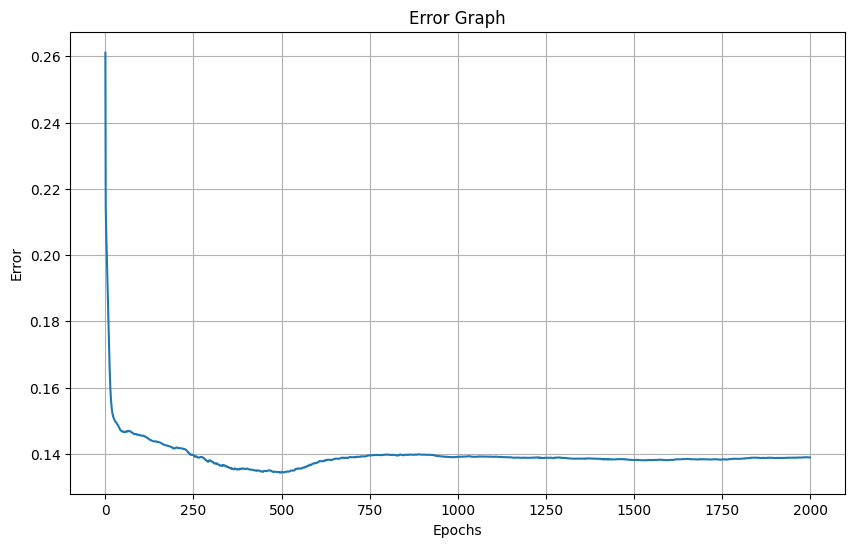

In [4]:
nn_nn_structure = NeuralNetwork()
training_errors = []

for epoch in range(2000):
  predictions = nn_nn_structure.feedForward(X_train)
  nn_nn_structure.backPropagation(X_train, train_labels, predictions)
  error = np.mean(np.square(predictions - train_labels))
  training_errors.append(error)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(training_errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error Graph')
plt.grid(True)
plt.show()


test_predictions = nn_nn_structure.feedForward(X_test)
test_predictions_classes = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

accuracy = accuracy_score(true_labels, test_predictions_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, test_predictions_classes, average=None, zero_division=0)


# Accuracy

In [5]:
print("Accuracy:", accuracy)

for class_index in range(len(label_encoder.classes_)):
  class_name = label_encoder.classes_[class_index]
  print(f"Class '{class_name}' — Precision: {precision[class_index]:.2f}, Recall: {recall[class_index]:.2f}, F1-score: {f1[class_index]:.2f}")

Accuracy: 0.629887054735013
Class 'CPUs' — Precision: 0.82, Recall: 0.87, F1-score: 0.85
Class 'Mobile Phones' — Precision: 0.70, Recall: 0.11, F1-score: 0.19
Class 'TVs' — Precision: 0.51, Recall: 1.00, F1-score: 0.68


# Get the expected input shape from the training data

In [6]:
input_shape = X_train.shape[1]
sample_input = np.zeros((1, input_shape))
print(nn_nn_structure.feedForward(sample_input))

[[8.33175017e-01 1.66661151e-01 1.63832922e-04]]
